In [3]:
# Let us load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif

warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
train = pd.read_csv("../data/porto-seguro-safe-driver-prediction/train.csv")
train.head(1)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1


In [6]:
print(f"The train dateset contains {train.shape[0]} rows and {train.shape[1]} columns")

The train dateset contains 595212 rows and 59 columns


### 1. Data Quality checks
__Null or missing values check__

In [9]:
train.isnull().any().any()

False

In [11]:
train_copy = train.copy()
train_copy = train_copy.replace(-1, np.NaN)

In [ ]:
train_copy.isnull().sum()

<AxesSubplot:>

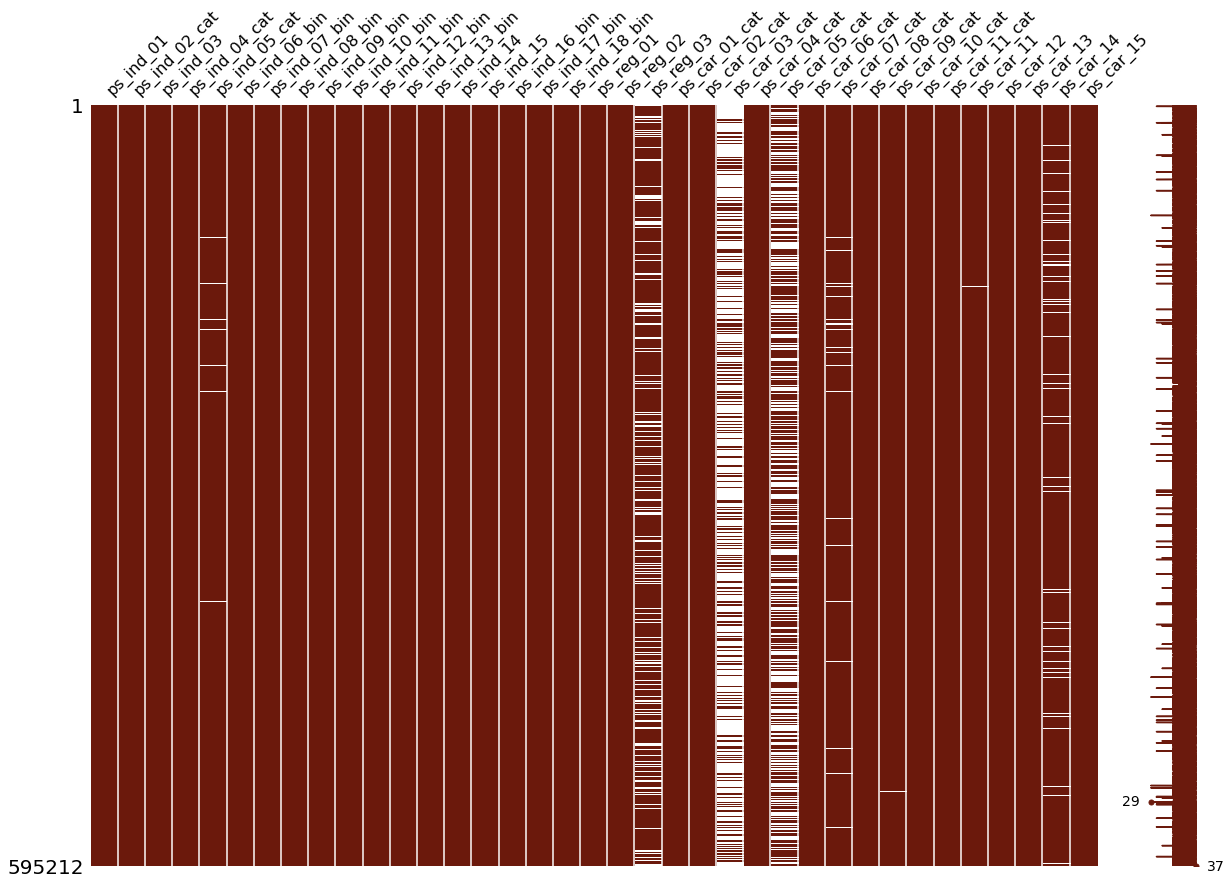

In [12]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df = train_copy.iloc[:, 2:39], figsize = (20, 14), color = (0.42, 0.1, 0.05))

### Target variable inspection

In [18]:
data = [go.Bar(
    x = train["target"].value_counts().index.values,
    y = train["target"].value_counts().values,
    text = "Distribution of target variable"
)]

layout = go.Layout(
    title = "Target variable distribution"
)

fig = go.Figure(data = data, layout = layout)

py.iplot(fig, filename = "basic-bar")

### Datatype check

In [24]:
# Country 사용방법
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [25]:
# value_counts() 사용방법
train.dtypes.value_counts()

int64      49
float64    10
dtype: int64

In [27]:
train_float = train.select_dtypes(include = ["float64"])
train_int = train.select_dtypes(include = ["int64"])

### Correlation plots
- [color map](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
- linewidths : 각 셀을 분할하는 라인의 너비
- vmax, vmin : 색으로 표현하는 값의 최댓값, 최솟값 설정
- square : True로 설정하면 정사각형 모양으로 출력
- annot : 각 셀안에 값 표현

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

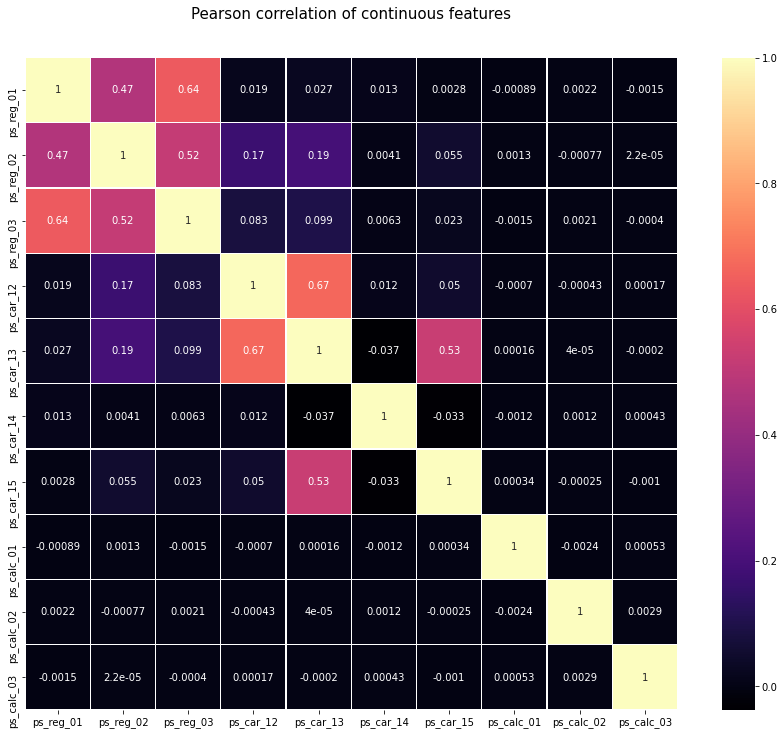

In [31]:
colormap = plt.cm.magma
plt.figure(figsize = (16,12))
plt.title("Pearson correlation of continuous features", y = 1.05, size = 15)
sns.heatmap(train_float.corr(), linewidths = 0.1, vmax = 1.0, square = True,
           cmap = colormap, linecolor = "white", annot = True)

#### 상관성이 높은 변수들
ps_reg_01, ps_reg_03 : 0.64

ps_reg_02, ps_reg_03 : 0.52

ps_car_12, ps_car_13 : 0.67

ps_car_13, ps_car_15 : 0.53

In [ ]:
train_int

In [38]:
data = [
    go.Heatmap(
        z= train_float.corr().values,
        x=train_float.columns.values,
        y=train_float.columns.values,
        colorscale='Viridis',
        reversescale = False,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Float-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

- In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal.
- 독립변수 명에 bin 과 cat이 붙은 것들을 제외한 변수들은 순서형 혹은 연속형 변수이다.
- 따라서, float형식을 제외한 int 타입을 가진 변수들은 순서형이라고 유추할 수 있다.(물론, 범주형 변수제외)

In [57]:
ordinal_check_df = pd.DataFrame({"columns":train.columns.tolist()})

In [63]:
ordinal_check_df = ordinal_check_df[~ordinal_check_df["columns"].str.contains("bin|cat|id|target")]

In [66]:
ordinal_check_cols = ordinal_check_df["columns"].tolist()

In [72]:
train_ordinal = train[ordinal_check_cols].select_dtypes(include = ["int64"])

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

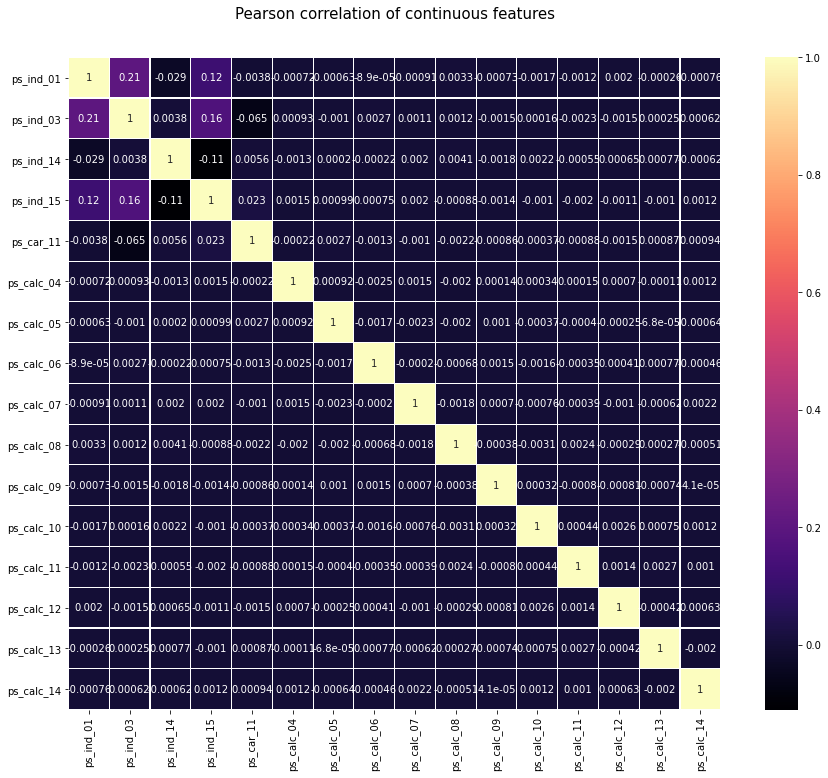

In [73]:
plt.figure(figsize = (16,12))
plt.title("Pearson correlation of continuous features", y = 1.05, size = 15)
sns.heatmap(train_ordinal.corr(method = "spearman"), linewidths = 0.1, vmax = 1.0, square = True,
           cmap = colormap, linecolor = "white", annot = True)

In [74]:
mf = mutual_info_classif(train_float.values,train.target.values,n_neighbors=3, random_state=17 )
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


### Binary features inspection

In [75]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [76]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

- ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin
- 변수들은 0 target 변수가 대부분을 차지하고 있으므로 타겟 분류에 많은 정보를 가지고 있지 않다는 것을 알 수 있다.

In [77]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [86]:
from sklearn.inspection import permutation_importance

In [89]:
importance = permutation_importance(rf, X= train.drop(['id', 'target'],axis=1),
                      y = train.target, n_repeats = 30, random_state = 0)

In [92]:
x, y = (list(x) for x in zip(*sorted(zip(importance["importances_mean"], features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [111]:
contusion_matrix = pd.crosstab(train["ps_ind_04_cat"], train["ps_car_01_cat"])

In [114]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [117]:
a = cramers_v(train["ps_ind_04_cat"], train["ps_car_01_cat"])

In [109]:
train["ps_ind_04_cat"] = train["ps_ind_04_cat"].map({-1:0, 1:1, 0:0})

In [110]:
train["ps_car_01_cat"] = train["ps_car_01_cat"].apply(lambda x:0 if x == -1 else x)